# Introduction to machine learning 2022 term project

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn models
from sklearn.model_selection import cross_validate,cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,BayesianRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier


#Feature selection imports
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing

In [2]:
npf = pd.read_csv("npf_train.csv")
hidden_test = pd.read_csv("npf_test_hidden.csv")

## Data preprocessing

Column "class2" added that is "event" if "class4" is Ib, Ia or II, otherwise labeled as "nonevent". 

In [3]:
class2 = np.array(["nonevent", "event"])
npf["class2"] = class2[(npf["class4"]!="nonevent").astype(int)]


## PCA 
PCA was performed inorder to help with the selection of component and for visualization of data.

In [4]:
npf_filtered = npf.filter(regex=".mean|.std")
scaled = preprocessing.scale(npf_filtered)

hidden_test_filtered = hidden_test.filter(regex=".mean|.std")
scaled_hidden_test = preprocessing.scale(hidden_test_filtered)

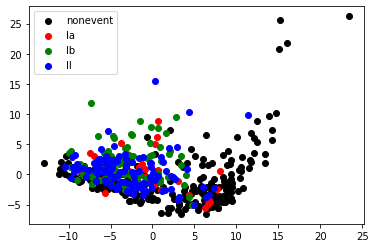

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled)
X = pca.transform(scaled)
class_to_color = {"nonevent":"k","Ia":"r","Ib":"g","II":"b"}

for k in class_to_color.keys():
    mask = npf["class4"] == k
    plt.scatter(X[mask,0],X[mask,1],c=class_to_color[k],label=k)
plt.legend()
plt.show()

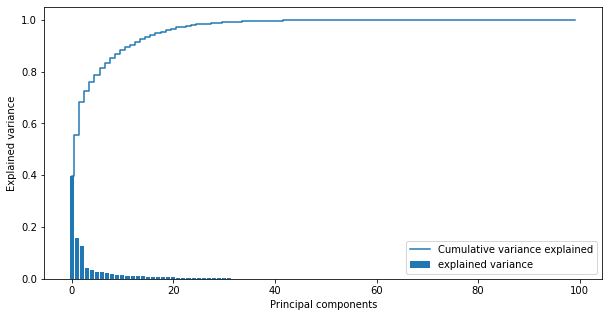

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
pca = PCA()
pca.fit(scaled)
pca_data = pca.transform(scaled)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca,label='explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative variance explained')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

## Feature selection and test/train splitting 

In [27]:
number_pca_components = 10
pca_df = pd.DataFrame(pca_data[:,:number_pca_components],
                      columns = ["pc" + str(i) for i in range(0,number_pca_components)])
pca_df["class2"] = npf["class2"]
pca_df["class4"] = npf["class4"]
train, test = train_test_split(pca_df,test_size=0.33, random_state=42)
print("Train size:", len(train),"Test size:", len(test))

Train size: 310 Test size: 154


In [12]:
X = train.filter(regex="pc")
#X = train.filter(regex=".mean")
y = train["class2"]
X_test = test.filter(regex="pc")
y_test = test["class2"]

## Benchmarking
At this point several different classifiers were tested inorder to get an idea of their relative performance.

In [13]:
Classifier_Names = ["dummyRegressor",
                    "logisticRegressor",
                    "GaussianNaiveBays",
                    "SVC",
                    "SVC-sigmoid",
                    "SVC-poly",
                    "RandomForest",
                    "AdaBoost",
                    "NearestNeighbour",
                    "GaussianProcess",
                    "QDA",
                    "DecisionTree"]


models = [DummyClassifier(strategy="prior"),
          LogisticRegression(penalty="l1",solver="liblinear"),
          GaussianNB(),
          SVC(probability=True),
          SVC(kernel="sigmoid",probability=True),
          SVC(kernel="poly",probability=True),
          RandomForestClassifier(),
          AdaBoostClassifier(),
          KNeighborsClassifier(3),
          GaussianProcessClassifier(1.0 * RBF(1.0)),
          QuadraticDiscriminantAnalysis(),
          DecisionTreeClassifier(max_depth=5)
          ]
res = pd.DataFrame(index=Classifier_Names)

In [14]:
#perplexity = lambda p: np.exp(-np.mean(np.log((test["class2"]!="nonevent").astype(int)*p + (1 - (test["class2"]!="nonevent").astype(int)) * (1 - p))))
#perplexity = lambda p: 

In [15]:
res["train"] = [m.fit(X,y).score(X,y) for m in models]
res["cv"] = [cross_val_score(m, X, y, cv=10).mean() for m in models]
res["test"] = [m.fit(X,y).score(X_test,y_test) for m in models]
#res["perplexity"] = [perplexity(m.fit(X,y).predict_proba(X_test)[:,1]) for m in models]

In [16]:
res

,train,cv,test
dummyRegressor,0.522581,0.522581,0.454545
logisticRegressor,0.864516,0.854839,0.876623
GaussianNaiveBays,0.819355,0.803226,0.811688
SVC,0.893548,0.870968,0.857143
SVC-sigmoid,0.777419,0.793548,0.824675
SVC-poly,0.854839,0.825806,0.818182
RandomForest,1.000000,0.864516,0.876623
AdaBoost,0.980645,0.841935,0.857143
NearestNeighbour,0.916129,0.851613,0.876623
GaussianProcess,0.887097,0.851613,0.883117


## Choise of model
At this point we chose the logistic regression as the model for the production version of the classifier as it performed well and is a model that has good explainability. 

In [17]:
clf = LogisticRegression(penalty="l1",solver="liblinear")

clf.fit(X,y)

LogisticRegression(penalty='l1', solver='liblinear')

In [18]:
stats = pd.DataFrame(index=["logistic regression"], columns=["train","test","perplexity"])

stats["train"]      = clf.score(X,y)
stats["test"]       = clf.score(X_test,y_test)
#stats["perplexity"] = perplexity(clf.predict_proba(X_test)[:,1])
stats

,train,test,perplexity
logistic regression,0.864516,0.876623,NaN


## Production version and prediction of hidden test data 

In [19]:
X_prod = pca_df.filter(regex="pc")
y_prod = pca_df["class2"]
hidden_data = pca.transform(scaled_hidden_test)
hidden_df   = pd.DataFrame(hidden_data[:,:number_pca_components],
                      columns = ["pc" + str(i) for i in range(0,number_pca_components)])
X_test = hidden_df.filter(regex="pc")
clf.fit(X_prod,y_prod)
print("Training score:",clf.score(X_prod,y_prod))

Training score: 0.8728448275862069


In [20]:
hidden_test["class2"] = clf.predict(X_test)
hidden_test.to_csv("answers.csv")

In [21]:
test_not_hidden = pd.read_csv("npf_test.csv")
test_not_hidden["class2"] = class2[(test_not_hidden["class4"]!="nonevent").astype(int)]

hidden_test_filtered = test_not_hidden.filter(regex=".mean|.std")
scaled_test = preprocessing.scale(hidden_test_filtered)
test_data = pca.transform(scaled_test)
test_df   = pd.DataFrame(hidden_data[:,:number_pca_components],
                      columns = ["pc" + str(i) for i in range(0,number_pca_components)])
X_test_not_hidden = test_df.filter(regex="pc")
y_test_not_hidden = test_not_hidden["class2"]

In [22]:
clf.score(X_test_not_hidden,y_test_not_hidden)

0.8435233160621761

## Multi-class classifier

In [30]:
train, test = train_test_split(pca_df,test_size=0.33, random_state=42)
X = train.filter(regex="pc")
y = train["class4"]
X_test = test.filter(regex="pc")
y_test = test["class4"]

In [31]:
clf.fit(X,y)

LogisticRegression(penalty='l1', solver='liblinear')

In [32]:
stats = pd.DataFrame(index=["logistic regression"], columns=["train","test"])
stats["train"]      = clf.score(X,y)
stats["test"]       = clf.score(X_test,y_test)
stats

,train,test
logistic regression,0.677419,0.701299


In [35]:
y_test_not_hidden = test_not_hidden["class4"]
clf.score(X_test_not_hidden,y_test_not_hidden)

0.6673575129533679